# **Summarize PDF files using Lang Chain and OpenAI  and Create a Web Interface**

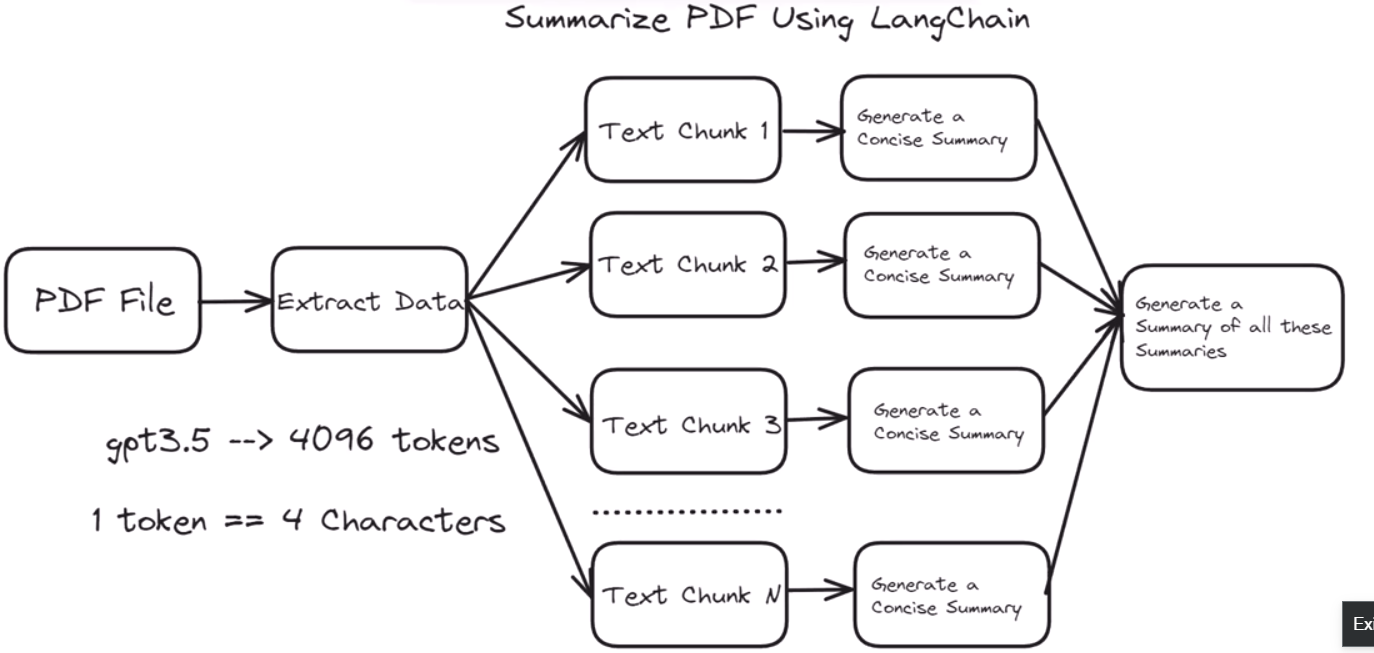

#**Step 01: Install All the Required Packages**

In [1]:
!pip install -q gradio openai pypdf tiktoken langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.9/283.9 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 48.1 MB

In [2]:
!pip install langchain-openai -q
!pip install tiktoken -q


#**Step 02: Import All the Required Libraries**

In [4]:
import os
import tiktoken
import gradio as gr
# from langchain.llms import OpenAI
from langchain.chains import LLMChain, SequentialChain
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate
from langchain_openai import OpenAI

from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

#**Step 03: Setting the Environment**

In [5]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

#**Step 04: Count the Number of Tokens in a String**

In [6]:
def num_tokens_from_string(string:str, encoding_name:str) -> int:
  #Returns the Number of Token in a text string
  encoding = tiktoken.get_encoding(encoding_name)
  num_tokens=len(encoding.encode(string))
  return num_tokens

In [7]:
num_tokens_from_string("Hello how are you", "cl100k_base")

4

#**Step 05: Download the GPT4ALL Technical Report**

In [8]:
!wget https://s3.amazonaws.com/static.nomic.ai/gpt4all/2023_GPT4All_Technical_Report.pdf

--2024-01-25 10:33:18--  https://s3.amazonaws.com/static.nomic.ai/gpt4all/2023_GPT4All_Technical_Report.pdf
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.89.222, 52.217.116.32, 54.231.203.120, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.89.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3651423 (3.5M) [application/pdf]
Saving to: ‘2023_GPT4All_Technical_Report.pdf’

2023_GPT4All_Techni 100%[===================>]   3.48M  16.6MB/s    in 0.2s    

2024-01-25 10:33:19 (16.6 MB/s) - ‘2023_GPT4All_Technical_Report.pdf’ saved [3651423/3651423]



#**Step 06: Load, Read and Extract Text From the PDF**

In [9]:
loader=PyPDFLoader("/content/2023_GPT4All_Technical_Report.pdf")

In [10]:
docs=loader.load()

In [11]:
docs

[Document(page_content='GPT4All: Training an Assistant-style Chatbot with Large Scale Data\nDistillation from GPT-3.5-Turbo\nYuvanesh Anand\nyuvanesh@nomic.aiZach Nussbaum\nzanussbaum@gmail.com\nBrandon Duderstadt\nbrandon@nomic.aiBenjamin Schmidt\nben@nomic.aiAndriy Mulyar\nandriy@nomic.ai\nAbstract\nThis preliminary technical report describes the\ndevelopment of GPT4All, a chatbot trained\nover a massive curated corpus of assistant in-\nteractions including word problems, story de-\nscriptions, multi-turn dialogue, and code. We\nopenly release the collected data, data cura-\ntion procedure, training code, and final model\nweights to promote open research and repro-\nducibility. Additionally, we release quantized\n4-bit versions of the model allowing virtually\nanyone to run the model on CPU.\n1 Data Collection and Curation\nWe collected roughly one million prompt-\nresponse pairs using the GPT-3.5-Turbo OpenAI\nAPI between March 20, 2023 and March 26th,\n2023. To do this, we first ga

In [12]:
docs[1]

Document(page_content='(a) TSNE visualization of the final training data, ten-colored\nby extracted topic.\n(b) Zoomed in view of Figure 2a. The region displayed con-\ntains generations related to personal health and wellness.\nFigure 2: The final training data was curated to ensure a diverse distribution of prompt topics and model responses.\n2.1 Reproducibility\nWe release all data (including unused P3 genera-\ntions), training code, and model weights for the\ncommunity to build upon. Please check the Git\nrepository for the most up-to-date data, training\ndetails and checkpoints.\n2.2 Costs\nWe were able to produce these models with about\nfour days work, $800 in GPU costs (rented from\nLambda Labs and Paperspace) including several\nfailed trains, and $500 in OpenAI API spend.\nOur released model, gpt4all-lora, can be trained in\nabout eight hours on a Lambda Labs DGX A100\n8x 80GB for a total cost of $100 .\n3 Evaluation\nWe perform a preliminary evaluation of our model\nusing the 

#**Step 07: Split the Text into Chunks**

In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

In [14]:
texts=text_splitter.split_documents(docs)

In [15]:
len(texts)

8

#**Step 08: Load the OpenAI Model**


In [16]:
llm=OpenAI(api_key=OPENAI_API_KEY)

In [18]:
llm.model_name

'gpt-3.5-turbo-instruct'

In [19]:
chain = load_summarize_chain(llm, chain_type='map_reduce', verbose=True)

In [20]:
chain.invoke(texts)



> Entering new MapReduceDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"GPT4All: Training an Assistant-style Chatbot with Large Scale Data
Distillation from GPT-3.5-Turbo
Yuvanesh Anand
yuvanesh@nomic.aiZach Nussbaum
zanussbaum@gmail.com
Brandon Duderstadt
brandon@nomic.aiBenjamin Schmidt
ben@nomic.aiAndriy Mulyar
andriy@nomic.ai
Abstract
This preliminary technical report describes the
development of GPT4All, a chatbot trained
over a massive curated corpus of assistant in-
teractions including word problems, story de-
scriptions, multi-turn dialogue, and code. We
openly release the collected data, data cura-
tion procedure, training code, and final model
weights to promote open research and repro-
ducibility. Additionally, we release quantized
4-bit versions of the model allowing virtually
anyone to run the model on CPU.
1 Data Collection and Curation
We collected roughly one million prompt-
response pai

{'input_documents': [Document(page_content='GPT4All: Training an Assistant-style Chatbot with Large Scale Data\nDistillation from GPT-3.5-Turbo\nYuvanesh Anand\nyuvanesh@nomic.aiZach Nussbaum\nzanussbaum@gmail.com\nBrandon Duderstadt\nbrandon@nomic.aiBenjamin Schmidt\nben@nomic.aiAndriy Mulyar\nandriy@nomic.ai\nAbstract\nThis preliminary technical report describes the\ndevelopment of GPT4All, a chatbot trained\nover a massive curated corpus of assistant in-\nteractions including word problems, story de-\nscriptions, multi-turn dialogue, and code. We\nopenly release the collected data, data cura-\ntion procedure, training code, and final model\nweights to promote open research and repro-\nducibility. Additionally, we release quantized\n4-bit versions of the model allowing virtually\nanyone to run the model on CPU.\n1 Data Collection and Curation\nWe collected roughly one million prompt-\nresponse pairs using the GPT-3.5-Turbo OpenAI\nAPI between March 20, 2023 and March 26th,\n2023. To 

#**Step 09: Create a Simple Gradio UI**

In [21]:
def summarize_pdf(pdf_file_path):
  loader=PyPDFLoader(pdf_file_path)
  docs=loader.load()
  text_splitter=RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
  texts=text_splitter.split_documents(docs)
  chain=load_summarize_chain(llm, chain_type="map_reduce")
  summary=chain.run(texts)
  return summary

In [22]:
input_pdf_path=gr.components.Textbox(label="Provide the PDF File Path ")
output_summary=gr.components.Textbox(label="Summary")

interface=gr.Interface(
    fn=summarize_pdf,
    inputs=input_pdf_path,
    outputs=output_summary,
    title="PDF Summarizer",
    description="Provide PDF File Path to get the Summary"
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b8cd65fd2e6f146ef0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


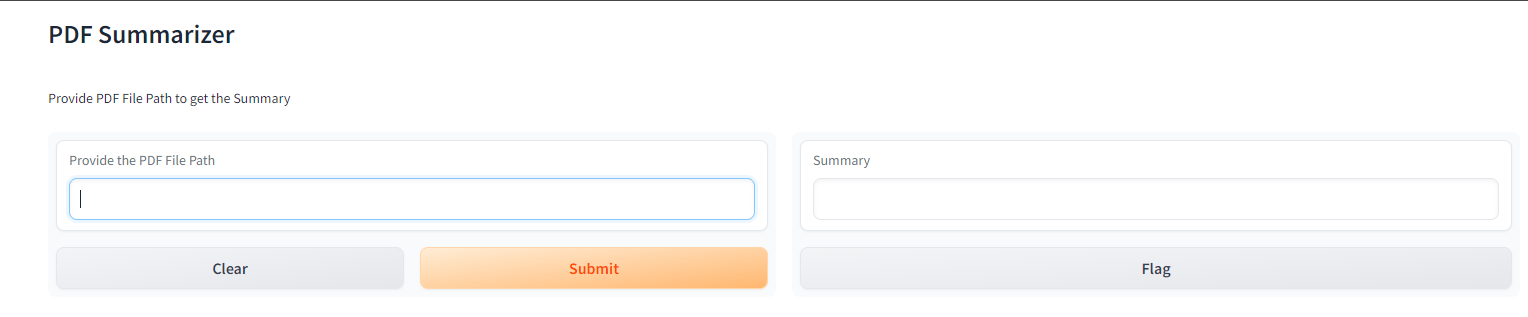

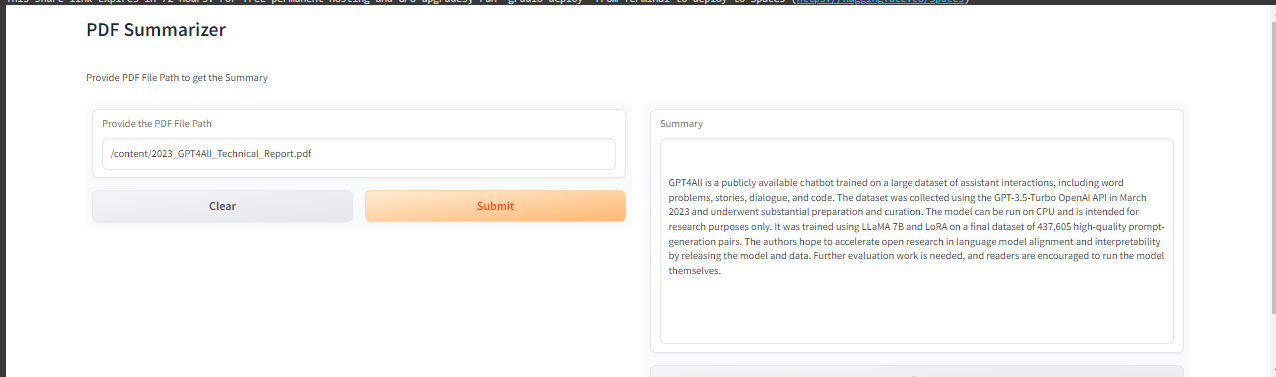